# Total Energy Expenditure by Mass Scatter Plot

The plot that will be reproduced in this example is a log-log scatter plot of total energy expenditure (kcal/day) against mass (kg) as published by Pontzer et al. (2014) in PNAS (doi: [10.1073/pnas.1316940111](http://dx.doi.org/10.1073/pnas.1316940111)). Log-log plots of this sort are fairly common in biological anthropology, and this one has some of the common complications: multiple fitted lines, confidence intervals, different colored points for different groups, and some annotations.

![](images/energyexpenditure_plot.png)

The data underlying this plot are included in the supplementary material of the paper and have been extracted and made available in my bioanth datasets repository.

## Some preliminaries

First, I always change the R option for importing strings (I find that the default convert to factor causes more problems than it solves).

In [77]:
options(stringsAsFactors=F)

Next, import the data. The resulting data frame has five variables: species, order, captive, mass (in kg), and tee (total energy expenditure in kcal/day).

In [78]:
dset = read.csv(url("https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/energyexpenditure.csv"))
str(dset)

'data.frame':	86 obs. of  5 variables:
 $ species: chr  "Microcebus_murinus" "Lepilemur_ruficaudatus" "Eulemur" "Lemur_catta" ...
 $ order  : chr  "Primates" "Primates" "Primates" "Primates" ...
 $ captive: chr  "no" "no" "no" "no" ...
 $ mass   : num  0.064 0.77 1.84 2.24 2.21 4.9 7.12 12 72.2 46.6 ...
 $ tee    : num  28 121 146 146 217 ...


While it is possible to do log transformations on the fly, I find that doing so will lead to complications down the line, so it is best to just create new logged variables in the working data frame.

In [79]:
dset$logmass = log10(dset$mass)
dset$logtee = log10(dset$tee)

Because the target plot shows primates in red and nonprimates in black, it will be useful to have a variable for this color difference. 

In [80]:
point_color = ifelse(dset$order == "Primates", "red", "black")
table(point_color)

point_color
black   red 
   67    19 

In addition, the nonprimates and the non-captive primates have filled circles while the captive primates have non-filled ones, so a variable for this will be useful as well. Because there are missing data in the `captive` variable (unknown/missing for the nonprimates), and we want three different fills (black, red, none), the fill factor has to be constructed a little differently than the simple `ifelse` I used just above for the outline color.

In [81]:
# first make the variable and set everything to black
point_fill = rep(adjustcolor("black", alpha=0.5), nrow(dset)) # adjustcolor used to adjust transparency

# then update the entries that we don't want to be black
point_fill[dset$captive == "no"] = adjustcolor("red", alpha=0.5)
point_fill[dset$captive == "yes"] = "white" # background is white, so will appear to be no fill
table(point_fill)

point_fill
#00000080 #FF000080     white 
       67         8        11 

The target plot has three different OLS regression lines on it:

1. Nonprimates (black line)
2. Primates (red line)
3. Primates without the mouse lemur (red dashed line)

So these data subsets and regression models will be useful.

In [82]:
nonprimates = subset(dset, order != "Primates")
allprimates = subset(dset, order == "Primates")
subprimates = subset(allprimates, species != "Microcebus_murinus")

nonprimatesfit = lm(logtee ~ logmass, data=nonprimates)
allprimatesfit = lm(logtee ~ logmass, data=allprimates)
subprimatesfit = lm(logtee ~ logmass, data=subprimates)

## Base R

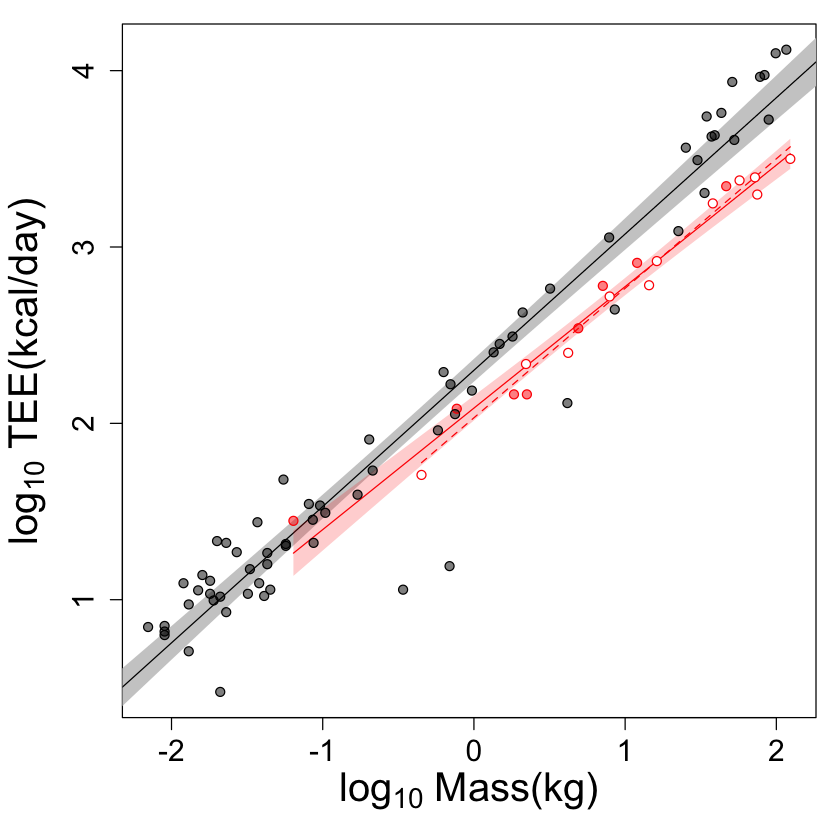

In [83]:
# To match the published plot, the axis legends need to be larger than the R default,
# and to make them fit into the plot area, the margins need to be changed.
# Because "par" settings are semi-permanent, I save the default settings in order
# to reset them at the end.
old.par = par(mar=c(5.1,5.1,1.0,1.0))

# set up the plot without any data points or lines
plot(logtee ~ logmass, 
     data=dset, 
     type='n', # 'none' - no points will be plotted
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     # the numbers below were arrived at by trial and error
     cex.lab=2,    # double the size of the labels
     cex.axis=1.5) # make the axis numbers 1.5 times usual size

# the lines, confidence intervals, and points need to added in the right order
# to ensure proper visibility - the lines have to go on top of the confidence 
# intervals, and the points need to go on last.

# First, the non-primates confidence interval and line
# generate a range of x-axis values (logmasses) to use in calculating the confidence interval
np_massrange = seq(-3, 3, length.out=100)
# calculate the point, upper, and lower estimates from the model
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
# plot a filled polygon covering the area between the upper and lower limits
polygon(c(rev(np_massrange), np_massrange),           # x values
        c(rev(np_interval[,3]), np_interval[,2]),     # y values
        col='grey80', border=NA)
# add the fitted line
abline(nonprimatesfit)

# Next, the all primates confidence interval and line, following the same basic
# procedure as for the non-primates line and interval
ap_massrange = seq(min(allprimates$logmass), max(allprimates$logmass), length.out=100)
ap_interval = predict(allprimatesfit, 
                      newdata=data.frame(logmass=ap_massrange), 
                      interval='confidence')
polygon(c(rev(ap_massrange), ap_massrange),           
        c(rev(ap_interval[,3]), ap_interval[,2]),     
        col=adjustcolor("red", alpha=.2),
        border=NA)
lines(c(min(ap_massrange), max(ap_massrange)),                  
      c(ap_interval[1,1], ap_interval[length(ap_massrange),1]), 
      col="red")

# Then add the primates without mouse lemur fitted line
sb_minmax = c(min(subprimates$logmass), max(subprimates$logmass))
sb_fitted = predict(subprimatesfit,
                      newdata=data.frame(logmass=sb_minmax))
lines(sb_minmax,  # x values for ends of line
      sb_fitted,  # y values for ends of line
      col="red",
      lty=2)      # dotted line

# Add the points
# first plot filled circles
with(dset, points(logmass, logtee, pch=16, col=point_fill))
# then overplot with open circles
with(dset, points(logmass, logtee, pch=1, col=point_color))

# Finally, reset plotting default parameters
par(old.par)

It is **possible** to add all the annotations that are in the original plot, but the code is ugly and probably pretty fragile (i.e. wouldn't hold up well to changing plot sizes). I include it here for illustration purposes, but I imagine that the annotations were added in later manually in the published plot.

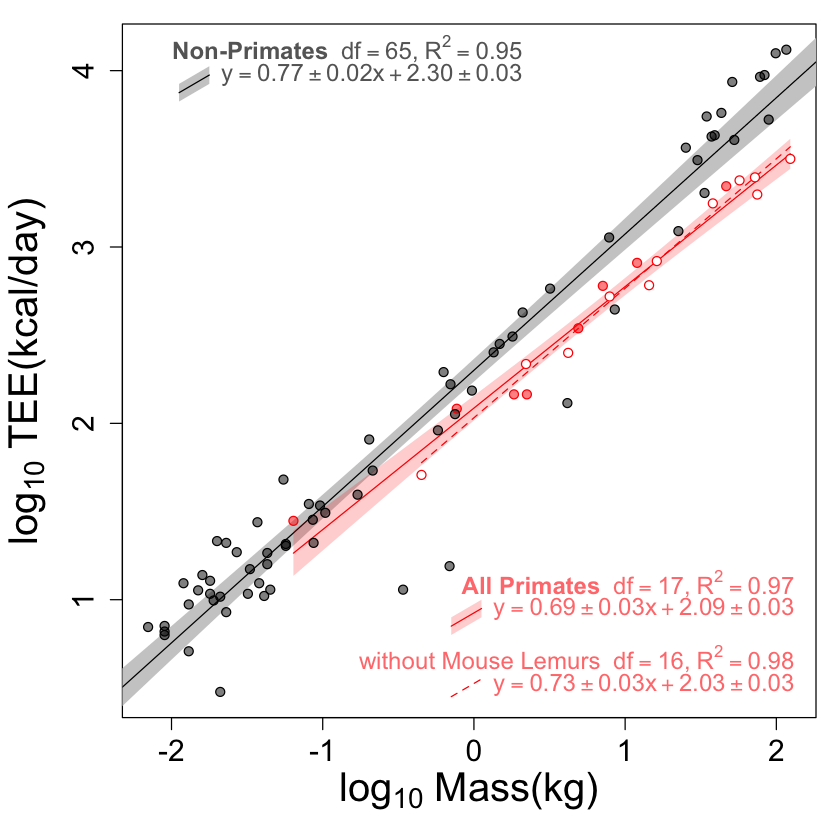

In [121]:
# plot with lines, confidence intervals, and points as before
par(mar=c(5.1,5.1,1.0,1.0))
plot(log10(tee) ~ log10(mass), 
     data=dset, 
     type='n',
     xlab=expression("log"[10]*" Mass(kg)"),
     ylab=expression("log"[10]*" TEE(kcal/day)"),
     cex.lab=2,
     cex.axis=1.5)

# non-primates confidence interval and line
np_massrange = seq(-3, 3, length.out=100)
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
polygon(c(rev(np_massrange), np_massrange),           
        c(rev(np_interval[,3]), np_interval[,2]),     
        col='grey80',
        border=NA)
abline(nonprimatesfit)

# all primates confidence interval and line 
ap_massrange = seq(min(allprimates$logmass), max(allprimates$logmass), length.out=100)
ap_interval = predict(allprimatesfit, 
                      newdata=data.frame(logmass=ap_massrange), 
                      interval='confidence')
polygon(c(rev(ap_massrange), ap_massrange),           
        c(rev(ap_interval[,3]), ap_interval[,2]),     
        col=adjustcolor("red", alpha=.2),
        border=NA)
lines(c(min(ap_massrange), max(ap_massrange)),                  
      c(ap_interval[1,1], ap_interval[length(ap_massrange),1]), 
      col="red")

# primates without mouse lemur line
sb_minmax = c(min(subprimates$logmass), max(subprimates$logmass))
sb_fitted = predict(subprimatesfit,
                      newdata=data.frame(logmass=sb_minmax))
lines(sb_minmax,     
      sb_fitted,  
      col="red",
      lty=2)

# points
with(dset, points(log10(mass), log10(tee), pch=16, col=point_fill))
with(dset, points(log10(mass), log10(tee), pch=1, col=point_color))

# Annotations

# First, pull out the coefficients and what not from the models
# All the formating and rounding here is to ensure that all of these
# numbers have exactly two decimal places

# numbers from the non-primates model
np_df = nonprimatesfit$df.residual                                            # df
np_r2 = format(round(summary(nonprimatesfit)$r.squared, 2), nsmall=2)         # R2
np_b0 = format(round(nonprimatesfit$coefficients[1], 2), nsmall=2)            # intercept
np_b1 = format(round(nonprimatesfit$coefficients[2], 2), nsmall=2)            # slope
np_e0 = format(round(summary(nonprimatesfit)$coefficients[1,2], 2), nsmall=2) # intercept s.e.
np_e1 = format(round(summary(nonprimatesfit)$coefficients[2,2], 2), nsmall=2) # slope s.e.

# numbers from the all primates model (same order as above)
ap_df = allprimatesfit$df.residual
ap_r2 = format(round(summary(allprimatesfit)$r.squared, 2), nsmall=2)
ap_b0 = format(round(allprimatesfit$coefficients[1], 2), nsmall=2)
ap_b1 = format(round(allprimatesfit$coefficients[2], 2), nsmall=2)
ap_e0 = format(round(summary(allprimatesfit)$coefficients[1,2], 2), nsmall=2)
ap_e1 = format(round(summary(allprimatesfit)$coefficients[2,2], 2), nsmall=2)

# numbers from the primates without mouse lemur model (same order as above)
sp_df = subprimatesfit$df.residual
sp_r2 = format(round(summary(subprimatesfit)$r.squared, 2), nsmall=2)
sp_b0 = format(round(subprimatesfit$coefficients[1], 2), nsmall=2)
sp_b1 = format(round(subprimatesfit$coefficients[2], 2), nsmall=2)
sp_e0 = format(round(summary(subprimatesfit)$coefficients[1,2], 2), nsmall=2)
sp_e1 = format(round(summary(subprimatesfit)$coefficients[2,2], 2), nsmall=2)

# get a value for the annotation text height to use in vertical spacing
txthght = 1.5*strheight("XXX", cex=1.2)

# starting location for top annotation
# these are the x,y coordinates that will be the right end of the text
x0 = 0.4; y0 = 4.1
# add text, 
text(x0, y0, pos=2, cex=1.2, col='grey40',
     labels=as.expression(bquote(bold('Non-Primates ') ~ df == .(np_df) * ',' ~ R^2 == .(np_r2))))
text(x0, y0-txthght, pos=2, cex=1.2, col='grey40',
     labels=as.expression(bquote(y == .(np_b1)%+-%.(np_e1)*x + .(np_b0)%+-%.(np_e0))))


x1 = 2.2; y1 = 0.5
text(x1, y1+4*txthght, pos=2, cex=1.2, col=adjustcolor("red", alpha=0.6),
     labels=as.expression(bquote(bold('All Primates ') ~ df == .(ap_df) * ',' ~ R^2 == .(ap_r2))))
text(x1, y1+3*txthght, pos=2, cex=1.2, col=adjustcolor("red", alpha=0.6),
     labels=as.expression(bquote(y == .(ap_b1)%+-%.(ap_e1)*x + .(ap_b0)%+-%.(ap_e0))))
text(x1, y1+txthght, pos=2, cex=1.2, col=adjustcolor("red", alpha=0.6),
     labels=as.expression(bquote('without Mouse Lemurs ' ~ df == .(sp_df) * ',' ~ R^2 == .(sp_r2))))
text(x1, y1, pos=2, cex=1.2, col=adjustcolor("red", alpha=0.6),
     labels=as.expression(bquote(y == .(sp_b1)%+-%.(sp_e1)*x + .(sp_b0)%+-%.(sp_e0))))

polygon(c(-1.95, -1.75, -1.75, -1.95),
        c(3.925, 4.025, 3.925, 3.825),     
        col='grey80',
        border=NA)
lines(c(-1.95, -1.75), c(3.875, 3.975))

polygon(c(-0.15, 0.05, 0.05, -0.15),
        c(0.8, 0.9, 1.0, 0.9),     
        col=adjustcolor("red", alpha=0.2),
        border=NA)
lines(c(-0.15, 0.05), c(0.85, 0.95), col="red")

lines(c(-0.15, 0.05), c(0.45, 0.55), col="red", lty=2)

# reset plotting default parameters
par(old.par)

## ggplot2

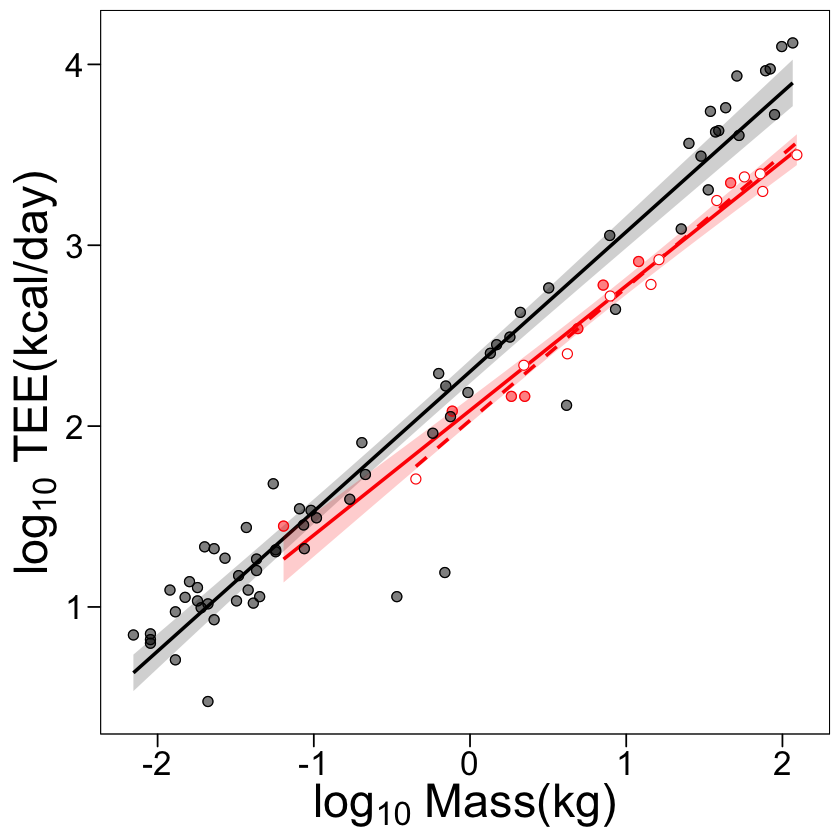

In [194]:
library(ggplot2)
library(ggthemes) # for the simple theme_base

plt = ggplot(dset, aes(x=logmass, y=logtee)) +
        # no gridlines, shading, etc.
        theme_base() + theme(plot.background = NULL) +  
        # make the axis tick labels a little bigger
        theme(axis.text = element_text(size=rel(1.25))) + 
        # make the axis legend text larger as well
        theme(axis.title=element_text(size=rel(1.75))) +
        # set the x- and y-axis legends
        xlab(expression("log"[10]*" Mass(kg)")) +
        ylab(expression("log"[10]*" TEE(kcal/day)")) +
        # add the non-primates line and confidence interval
        geom_smooth(data=nonprimates, aes(x=logmass, y=logtee), method="lm", color="black") +
        # add the all primates line and confidence interval
        geom_smooth(data=allprimates, aes(x=logmass, y=logtee), method="lm", color="red", fill="red", alpha=0.2) +
        # add the primates without mouse lemur line (without confidence interval)
        geom_smooth(data=subprimates, aes(x=logmass, y=logtee), method="lm", color="red", linetype=2, se=F) +
        # add the filled circles
        geom_point(color=point_fill, size=2.5) +
        # add the open circles on top
        geom_point(color=point_color, shape=1, size=2.5)

# show the plot
plt

Again, it is **possible** to add the annotations that are on the original plot. I'll add one of them here just to show, but again, it is probably not worth the effort.

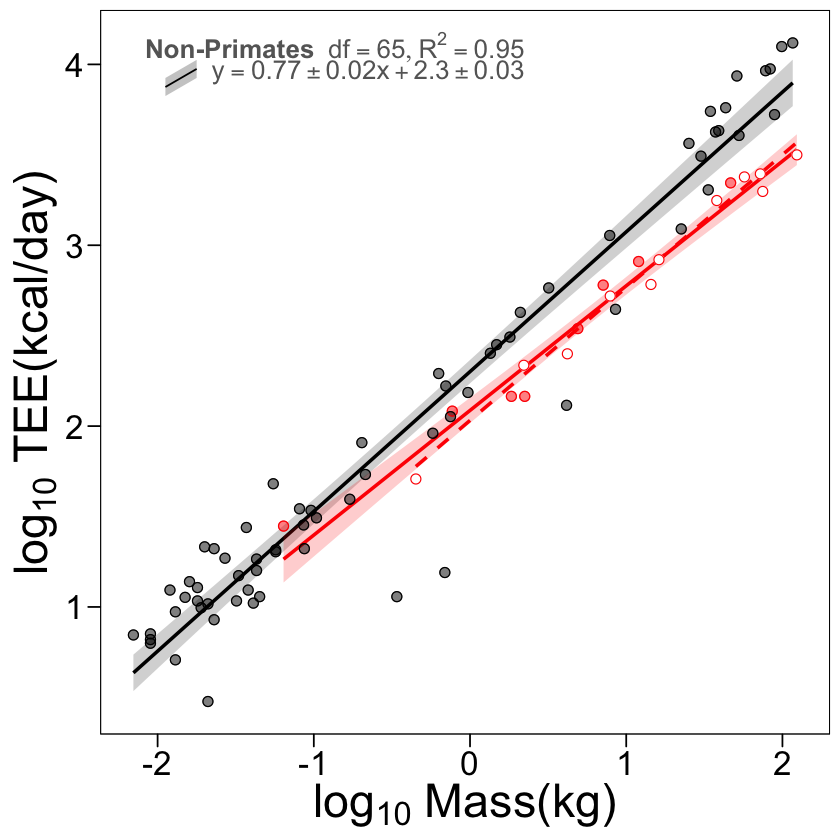

In [195]:
# will add the non primates model fit information, so as before
# starting location
x0 = 0.35; y0 = 4.1

# set up the labels ahead of time; all of the numbers (np_df, etc.) are from above in the base R example
# setting up the text for the labels is a little different as the symbols will be parsed while plotting
lab1 = paste("bold('Non-Primates ') ~ list(df == ", np_df, ", R^2 == ", np_r2, ")")
lab2 = paste("y == ", np_b1, "%+-%", np_e1, "*x + ", np_b0, "%+-%", np_e0)
both = paste(lab1, "\n", lab2)

# add the labels to the plot
plt = plt + annotate("text", x=x0, y=y0, hjust=1, label=lab1, parse=T, 
                     size=theme_get()$text[["size"]]/2, color='grey40') +
            annotate("text", x=x0, y=y0-txthght, hjust=1, label=lab2, parse=T, 
                     size=theme_get()$text[["size"]]/2, color='grey40') +
            annotate("polygon", fill="grey80", 
                     x=c(-1.95, -1.75, -1.75, -1.95), 
                     y=c(3.925, 4.025, 3.925, 3.825)) +
            annotate("line", x=c(-1.95, -1.75), y=c(3.875, 3.975))

# show the plot
plt

## lattice

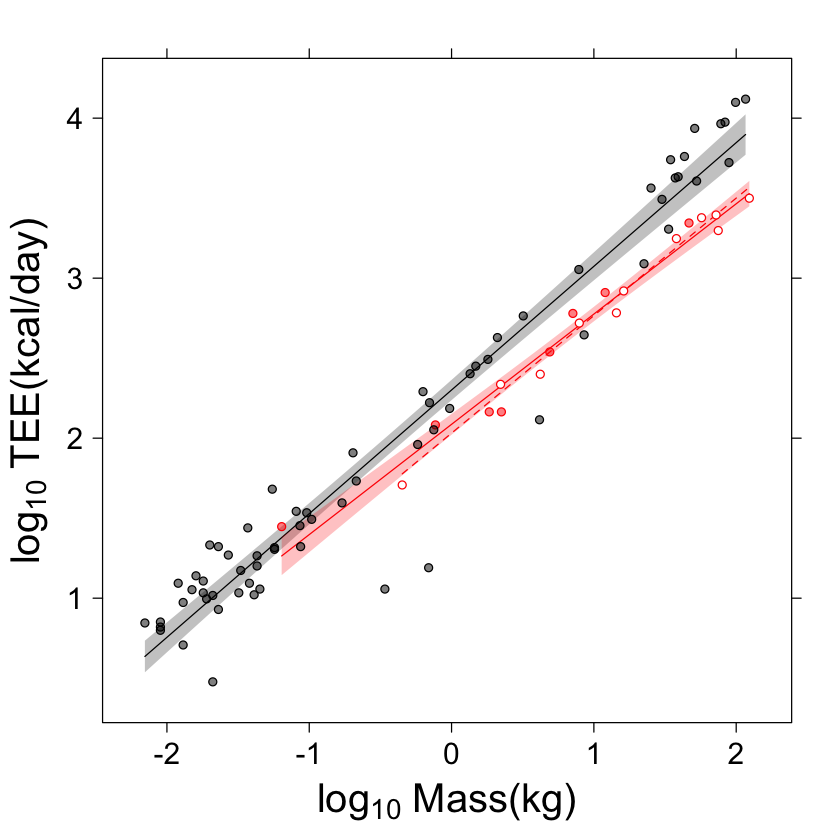

In [234]:
library(lattice)
library(latticeExtra)

xyplot(logtee ~ logmass, data=dset,
       xlab=list(label=expression("log"[10]*" Mass(kg)"), cex=2),
       ylab=list(label=expression("log"[10]*" TEE(kcal/day)"), cex=2),
       scales=list(x=list(cex=1.5), y=list(cex=1.5)),
       panel=function(x, y) {
           panel.smoother(nonprimates$logmass, nonprimates$logtee, method="lm", col="black")
           panel.smoother(allprimates$logmass, allprimates$logtee, method="lm", col="red")
           panel.smoother(subprimates$logmass, subprimates$logtee, method="lm", col="red", lty=2, se=F)
           panel.xyplot(x,y,pch=21,col=point_color,fill=point_fill)
      })  
